In [2]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df = pd.read_csv("/content/spam.csv", encoding='latin-1')

In [4]:
if 'Class' in df.columns and 'Message' in df.columns:
    data = df[['Class', 'Message']].copy()
elif 'v1' in df.columns and 'v2' in df.columns:
    data = df[['v1', 'v2']].copy()
    data.columns = ['Class', 'Message']
else:
    cols = df.columns.tolist()
    print("Columns found:", cols)
    data = df.iloc[:, :2].copy()
    data.columns = ['Class', 'Message']
    data.dropna(subset=['Message', 'Class'], inplace=True)
    data['Class'] = data['Class'].astype(str)

Columns found: ['class', 'message']


In [5]:
print("Dataset size:", data.shape)
print(data['Class'].value_counts())

Dataset size: (5572, 2)
Class
ham     4825
spam     747
Name: count, dtype: int64


In [6]:
#preprocessing
STOPWORDS = set(stopwords.words('english'))

In [7]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [w for w in text.split() if w not in STOPWORDS]
    return " ".join(tokens)

data['clean_msg'] = data['Message'].apply(clean_text)

In [10]:
data = data[data['clean_msg'].str.strip() != ''] #dropping empty messages
print("After cleaning:", data.shape)
print(data['clean_msg'].head())

After cleaning: (5564, 3)
0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry wkly comp win fa cup final tkts st ...
3                  u dun say early hor u c already say
4               nah think goes usf lives around though
Name: clean_msg, dtype: object


In [11]:
#label encoding
le = LabelEncoder()
data['label'] = le.fit_transform(data['Class'])  # e.g., ham->0, spam->1
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label mapping: {'ham': np.int64(0), 'spam': np.int64(1)}


In [12]:
#train-test split
X = data['clean_msg'].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train size:", len(X_train), "Test size:", len(X_test))

Train size: 4451 Test size: 1113


In [14]:
MAX_NUM_WORDS = 20000   # vocabulary size
MAX_SEQ_LEN = 100       # max sequence length
EMBEDDING_DIM = 100     # embedding dimension

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

print("Vocab size (actual):", min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1))
print("Example sequence:", X_train_seq[0][:20])
print("Padded shape:", X_train_pad.shape)

Vocab size (actual): 6679
Example sequence: [847]
Padded shape: (4451, 100)


In [15]:
def build_model(vocab_size, embed_dim=EMBEDDING_DIM, seq_len=MAX_SEQ_LEN):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_len))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

vocab_size = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)
model = build_model(vocab_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
BATCH_SIZE = 64
EPOCHS = 8

In [17]:
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mc = ModelCheckpoint('best_rnn_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, mc],
    verbose=1
)

Epoch 1/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8612 - loss: 0.4154

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 270ms/step - accuracy: 0.8617 - loss: 0.4136 - val_accuracy: 0.9484 - val_loss: 0.1711
Epoch 2/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9841 - loss: 0.0662

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 309ms/step - accuracy: 0.9841 - loss: 0.0659 - val_accuracy: 0.9798 - val_loss: 0.0708
Epoch 3/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - accuracy: 0.9929 - loss: 0.0229 - val_accuracy: 0.9731 - val_loss: 0.0915
Epoch 4/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.9977 - loss: 0.0080 - val_accuracy: 0.9821 - val_loss: 0.0714
Epoch 5/8
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - accuracy: 0.9978 - loss: 0.0082 - val_accuracy: 0.9776 - val_loss: 0.0797


In [18]:
#evaluate model
best_model = load_model('best_rnn_model.h5')

y_pred_prob = best_model.predict(X_test_pad).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("\nTest Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step

Test Metrics:
Accuracy: 0.9838
Precision: 0.9781
Recall: 0.8993
F1-score: 0.9371

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       964
        spam       0.98      0.90      0.94       149

    accuracy                           0.98      1113
   macro avg       0.98      0.95      0.96      1113
weighted avg       0.98      0.98      0.98      1113



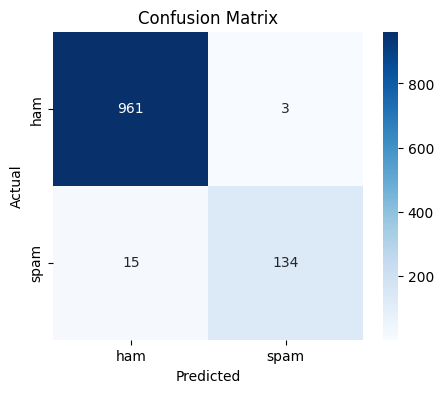

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

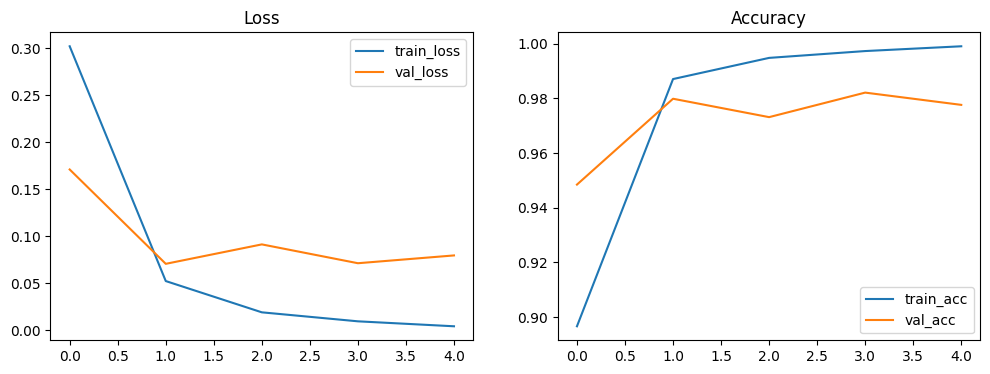

In [20]:
#plotting curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [21]:
#predictions
def predict_message(msg):
    clean = clean_text(msg)
    seq = tokenizer.texts_to_sequences([clean])
    pad = pad_sequences(seq, maxlen=MAX_SEQ_LEN, padding='post')
    prob = best_model.predict(pad)[0,0]
    label = le.inverse_transform([int(prob >= 0.5)])[0]
    return label, prob

examples = [
    "Congratulations! You've won a free ticket. Claim now.",
    "Please review the attached document and get back to me."
]
for ex in examples:
    lbl, p = predict_message(ex)
    print(f"\nMessage: {ex}\nPredicted: {lbl} (prob={p:.3f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Message: Congratulations! You've won a free ticket. Claim now.
Predicted: spam (prob=0.625)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Message: Please review the attached document and get back to me.
Predicted: ham (prob=0.037)
